# Wide parameter space searches and Machine learning for CW detection
Joe Bayley

Department of Physics and Astronomy

Univeristy of Glasgow

Searches for continuous gravitational waves come in a number of forms, generally targeted, directed and all-sky depending on the prior knowledge of the source. The following tutoral will be focussing on all-sky searches where there is no known prior knowledge of the source.

There are two main parts to this tutorial:
 * SOAP - the core SOAP algorithm and how to apply it to LIGO/Virgo/Kagra data
 * ML - how to apply machine learning to the same data-set (in this case for detection, in reality it is used more for line-vetoing)

 You can open this notebook in colab, which has some small amount of access to GPUs for free:
 
 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jcbayley/cwworkshop/blob/main/cwworkshop_soap.ipynb)

 The datasets we will use throughout this tutoral are much smaller than we will realistically get, 


## Installing and importing libraries

In [ ]:
!pip install soapcw

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soapcw
from soapcw import cw
import h5py
import torch
import os
import sys
import copy

cannot import matplotlib


## Downloading data

In [2]:
def fetch_data(url, filename):
    """Fetch data from a url and save it to given file"""
    if not os.path.isfile(filename):
        import urllib
        urllib.request.urlretrieve(url, filename=filename)
    else:
        print("File already exists!")

In [3]:
os.makedirs("data", exist_ok=True)
os.makedirs("pretrained_model_config", exist_ok=True)
even_url = "https://github.com/jcbayley/cwworkshop/raw/main/data/freq_100.0_106.1_3120_even.hdf5"
even_file = "data/freq_100.0_106.1_3120_even.hdf5"
fetch_data(even_url, even_file)
# Now for the training data
odd_url = "https://github.com/jcbayley/cwworkshop/raw/main/data/freq_100.0_106.1_3120_odd.hdf5"
odd_file = "data/freq_100.0_106.1_3120_odd.hdf5"
fetch_data(odd_url, odd_file)
# Now for model weights
weight_url = "https://github.com/jcbayley/cwworkshop/raw/main/pretrained_model_config/model_vitmapspectrogram_for_odd.pt"
weight_file = "pretrained_model_config/model_vitmapspectrogram_for_odd.pt"
fetch_data(weight_url, weight_file)
# Now for  config
config_url = "https://github.com/jcbayley/cwworkshop/raw/main/pretrained_model_config/pre_model.ini"
config_file = "pretrained_model_config/pre_model.ini"
fetch_data(config_url, config_file)

File already exists!
File already exists!
File already exists!
File already exists!


# SOAP

Documentation: https://joseph.bayley.docs.ligo.org/soapcw/viterbialgorithm.html 

SOAP (Snakes On A Plane) is a method to rapidly search for long duration signals in time-frequency spectrograms which do not follow any particular frequency evolution. This has the main goal of identifying signals that may be missed by traditional searches which use information on the expected signal to search for a signal.

There are multiple components to the SOAP search:
1. Initial frequency track identification (model agnostic)
2. ML followup to penalise instrumental lines (some model dependence)
3. Source parameter estimation from frequency tracks (model dependence)


##  Data Generation
Usage: https://joseph.bayley.docs.ligo.org/soapcw/usage/generate_cw_signal.html 

The SOAP package also has the ability to simulate spectrograms (i.e. time-frequency power spectra) of a CW signal. These are by default injected assuming the signal time-series is in stationary Gaussian noise, however, the PSD for each SFT can be changed and a signal can also be injected into real data. 

In [4]:
sig = cw.GenerateSignal()
# define signal parameters
sig.alpha = 3.7659              # right ascension
sig.delta = -0.060              # declination
sig.cosi = 0.434                # cosine of the inclination
sig.phi0 = 4.9115               # initial phase
sig.psi = 0.6667                # polarisation angle
sig.f = [200.03,-3.65e-11,0]    # frequency parameters [f, fdot, ...]
sig.tref = 1238166483.0         # reference time 
#sig.h0 = 3e-24                 #can be used along with a noise floor value, but we'll just just SNR

In [5]:
nsft = 48*200             # make 200 days of data (48, 1800s sfts = 1day)
tstart = 1238166483.0       # arbritrary start time
tsft = 1800.                # duration of 1 SFT
flow = 200.0                # lower frequency bound of sub-band
fhigh = 200.1               # upper frequency bound of sub-band
snr = 130                   # signal to noise ratio of signal
detectors = ["H1", "L1"]    # which detectors to simulate data for

In [6]:
spect = sig.get_spectrogram(
    tstart = tstart, 
    nsft=nsft,
    tsft=tsft,
    fmin=flow,
    fmax=fhigh,
    dets=detectors,
    snr=snr)

XLAL Error - XLALReadEphemerisFile (LALInitBarycenter.c:482): Failed to find ephemeris-file 'earth00-40-DE430.dat.gz[.gz]'

XLAL Error - XLALReadEphemerisFile (LALInitBarycenter.c:482): Invalid argument
XLAL Error - XLALInitBarycenter (LALInitBarycenter.c:252): XLALReadEphemerisFile('earth00-40-DE430.dat.gz') failed

XLAL Error - XLALInitBarycenter (LALInitBarycenter.c:252): Internal function call failed: Invalid argument


Could not load ephemeris file: earth00-40-DE430.dat.gz sun00-40-DE430.dat.gz, Internal function call failed: Invalid argument


Spectrograms are usually summed over 1 day to remove the antenna pattern modulation and increase the SNR (assuming the signal stays within a single frequency bin for a day).

In [7]:
spect.sum_sfts()

We can also compute the injected signal path to compare to our recovered signal later

In [8]:
# signal path in SFTs
h1_pulsar_path = sig.get_pulsar_path(spect.epochs, "H1")
# signal path in summed SFTs (taking mean over every 24 hours)
h1_summed_pulsar_path = np.mean(np.split(h1_pulsar_path, int(len(h1_pulsar_path)/48)), axis=1)

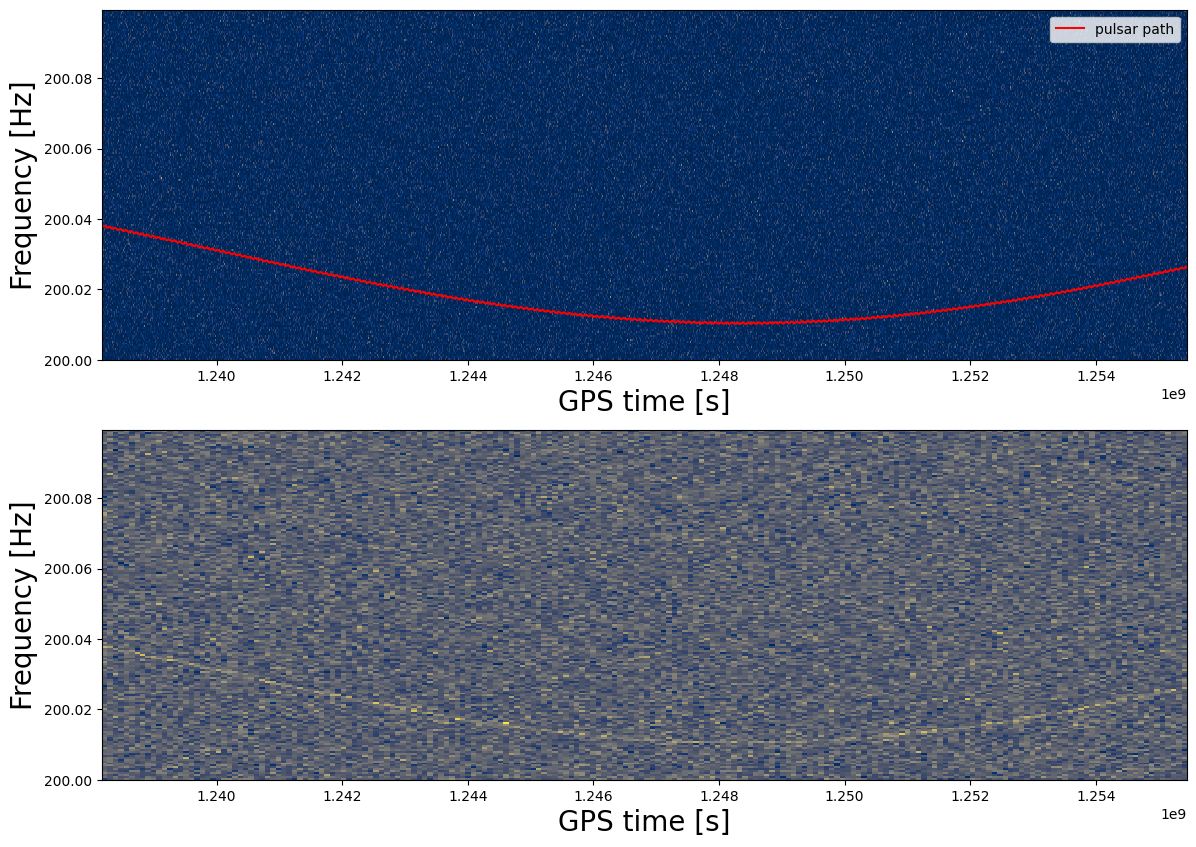

In [9]:
fig, ax = plt.subplots(nrows=2,figsize=(14,10))
ax[0].imshow(spect.H1.norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].plot(spect.epochs, h1_pulsar_path, "r", label="pulsar path")
ax[0].set_xlabel("GPS time [s]",fontsize=20)
ax[0].set_ylabel("Frequency [Hz]",fontsize=20)
ax[1].set_xlabel("GPS time [s]",fontsize=20)
ax[1].set_ylabel("Frequency [Hz]",fontsize=20)
ax[0].legend()

## Transisiton matrix
Documentation: https://joseph.bayley.docs.ligo.org/soapcw/transitionmatrix.html

The transition matrix defines the constraints that are placed on the track as it iterates between one time step and the next. In this case we are using multiple detectors therefore there are three components to the transition matrix. (up/down probability, geocenter to detector 1 probability, geocenter to detector 2 probability).

In this transition matrix, we make it very unlikely for each detector to have a signal in neighbouring frequency bins i.e. we enforce the signal to be in the same bin in each detector. We also make it ever so slightly more likely for a signal to jump straight than to jump up or down.

In [10]:
transition_matrix = soapcw.tools.transition_matrix_2d(1.1, 1e200,1e200)
print(transition_matrix)

[[[         -inf -461.64842071          -inf]
  [-461.64842071   -1.13140211 -461.64842071]
  [         -inf -461.64842071          -inf]]

 [[         -inf -461.55311053          -inf]
  [-461.55311053   -1.03609193 -461.55311053]
  [         -inf -461.55311053          -inf]]

 [[         -inf -461.64842071          -inf]
  [-461.64842071   -1.13140211 -461.64842071]
  [         -inf -461.64842071          -inf]]]


/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/soapcw/tools/tools.py:115: RuntimeWarning: divide by zero encountered in log
  return np.log(tr/np.sum(tr))


The SOAP algorithm can then be run by inputting the two normalised and summed spectrograms and the transition matrix.

In [11]:
soapout = soapcw.two_detector(transition_matrix, spect.H1.summed_norm_sft_power, spect.H1.summed_norm_sft_power)

We can look at the output spectrograms, with the true signal path and the predicted signal path overlayed.

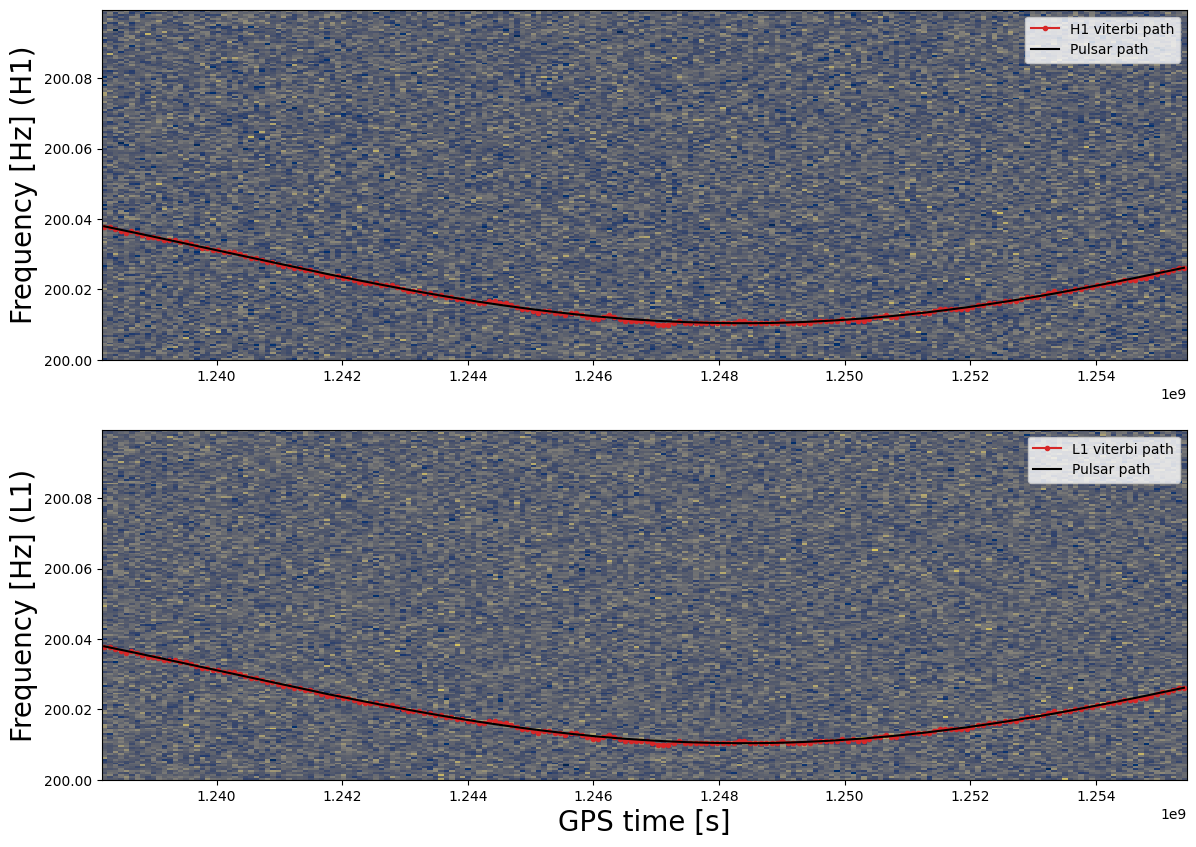

In [12]:
fig, ax = plt.subplots(nrows=2,figsize=(14,10))
half_day = 12*3600
ax[0].imshow(spect.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout.vit_track1], color="C3", marker="o", ms=3, label="H1 viterbi path")
ax[1].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout.vit_track2], color="C3", marker="o", ms=3, label="L1 viterbi path")
ax[0].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[1].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[1].set_xlabel("GPS time [s]",fontsize=20)
ax[0].set_ylabel("Frequency [Hz] (H1)",fontsize=20)
ax[1].set_ylabel("Frequency [Hz] (L1)",fontsize=20)
ax[0].legend()
ax[1].legend()

We can also view the viterbi map. we take the log of the viterbi map probabilities here just to make the features more visible. The which reigons are where the "probability" of signal is zero.

/var/folders/5g/x3mq__7j4q19_ymmlzpqqt9c0000gq/T/ipykernel_4160/429835647.py:2: RuntimeWarning: divide by zero encountered in log
  img=ax.imshow(np.log(soapout.vitmap.T), origin="lower", aspect="auto", extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")


Text(0, 0.5, 'Frequency [Hz]')

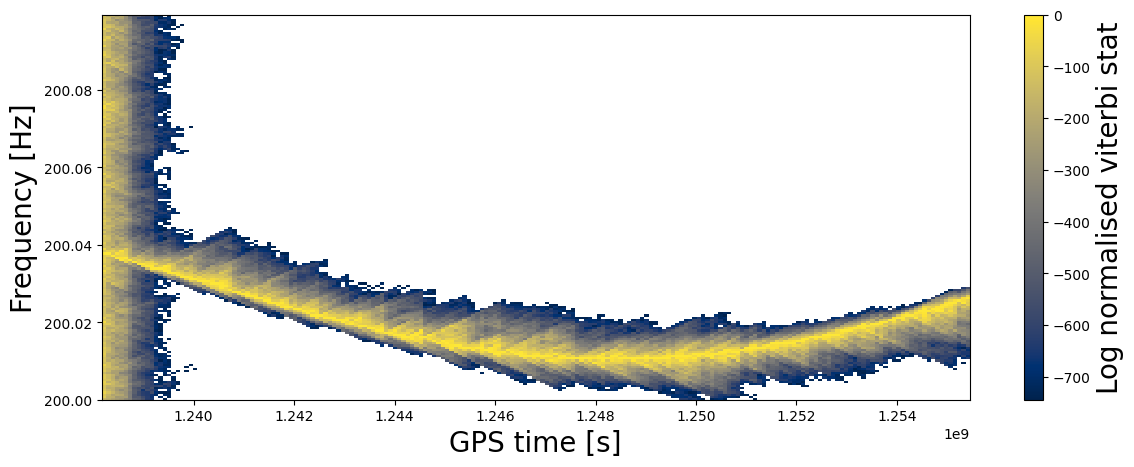

In [13]:
fig, ax = plt.subplots(figsize=(14,5))
img=ax.imshow(np.log(soapout.vitmap.T), origin="lower", aspect="auto", extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Log normalised viterbi stat", fontsize=20)
ax.set_xlabel("GPS time [s]",fontsize=20)
ax.set_ylabel("Frequency [Hz]",fontsize=20)

# Line aware statistic

Documentation: https://joseph.bayley.docs.ligo.org/soapcw/bayesianlineaware.html 

Usage: https://joseph.bayley.docs.ligo.org/soapcw/usage/generate_lookup_table.html

The Line aware statistic is designed to penalise instrumental lines compared to a signal model. This can only be used with two detectors and the penalisation comes from large differences in power between the detectors. 

More information about how this is derived can be found here: https://joseph.bayley.docs.ligo.org/soapcw/bayesianlineaware.html 

In [14]:
powers = np.linspace(1,400,10) # we use a low resolution for speed in this example

In [15]:
line_aware = soapcw.line_aware_stat.gen_lookup_python.LineAwareStatistic(
    powers,
    ndet=2,
    signal_prior_width=4.0,
    line_prior_width=10.0,
    noise_line_model_ratio=0.4
    )

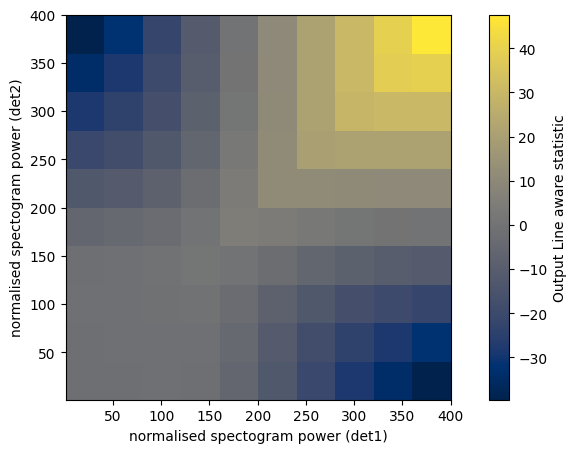

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
img = ax.imshow(np.log(line_aware.signoiseline),origin="lower",extent=[powers.min(),powers.max(),powers.min(),powers.max()], cmap="cividis")
ax.set_xlabel("normalised spectogram power (det1)")
ax.set_ylabel("normalised spectogram power (det2)")
fig.colorbar(img, ax=ax, label="Output Line aware statistic")

In [17]:
line_H1_summed_power = copy.copy(spect.H1.summed_norm_sft_power)
line_H1_summed_power[:,65:70] += 90

In [18]:
soapout_line = soapcw.two_detector(transition_matrix, line_H1_summed_power, spect.L1.summed_norm_sft_power, lookup_table_2det=line_aware)

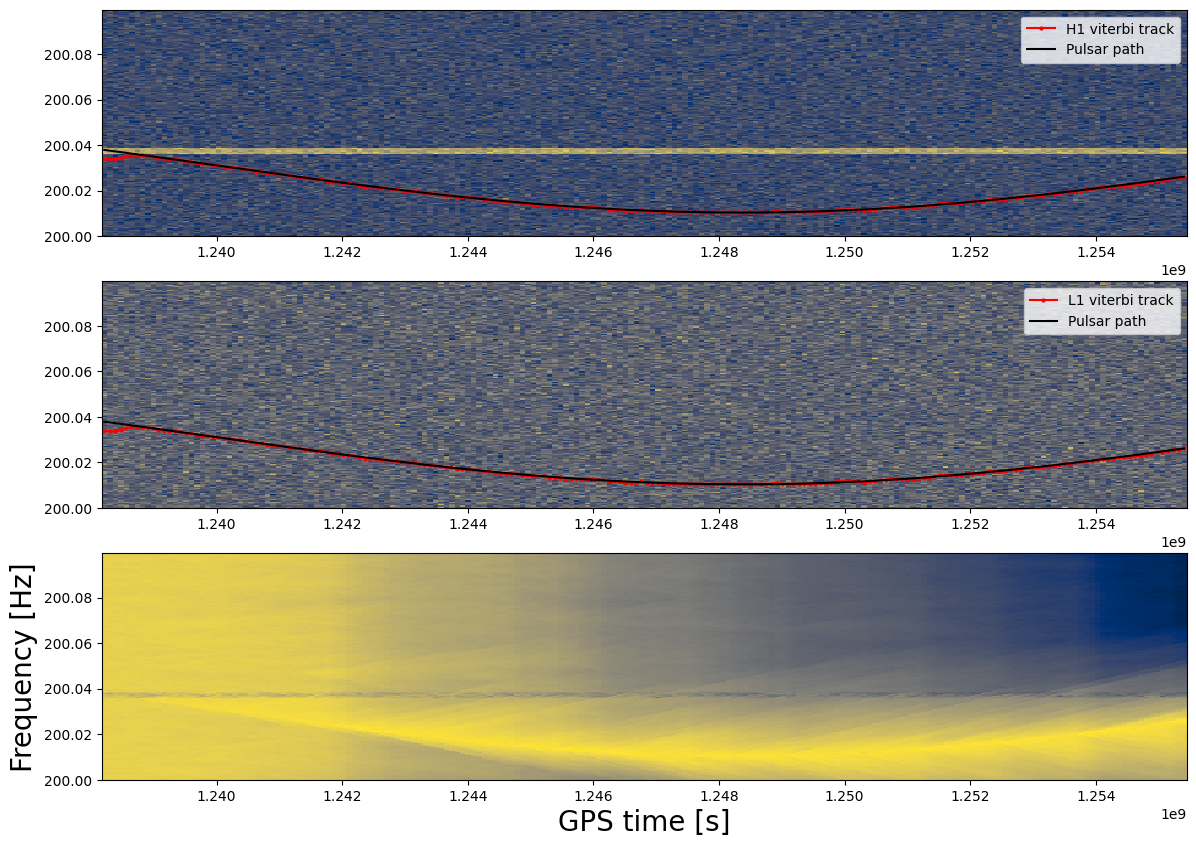

In [19]:
fig, ax = plt.subplots(nrows=3,figsize=(14,10))
ax[0].imshow(line_H1_summed_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout_line.vit_track1], color="r", marker="o", ms=2, label="H1 viterbi track")
ax[1].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout_line.vit_track2], color="r", marker="o", ms=2, label="L1 viterbi track")

ax[0].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[1].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[2].imshow(np.log(soapout_line.vitmap.T),aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")

ax[2].set_xlabel("GPS time [s]",fontsize=20)
ax[2].set_ylabel("Frequency [Hz]",fontsize=20)
ax[0].legend()
ax[1].legend()

# Data

Generating useable outputs from the search involves running on many narrow bands of data. We can do this on an example set provided. The provided data contains data with and without injections.

Noise: The noise is equivalent to a Gaussian noise time series, i.e. the power spectrum is a chi2 distribution with two degrees of freedom. 

Signal: The signal is injected with a given SNR, the square of which is used as the non centrality parameter for the noncentral chi2 distribution. The power is spread over multiple bins.

There is a third set of data here which contains some instrumental artefacts to more closely simulate real data.

Each of these datasets are a reduced set, so that we can run searches in a reasonable amount of time.
The duration is 20 days (1800s SFTs) and it covers a 4Hz frequency range (100-106 Hz), where each band in 0.02 Hz wide. As the spectrograms are summed over 1 day, this leaves us with images that are 20x36. 

The injected signals are all very loud with integrated SNRs in the range 30->40 over 10 days. This will allow the network to learn something with a reduced number of training examples. 

Prior on Signals

| name| symbol| range| info|
|-----|-----|-----|-----|
|right ascension | $\alpha$| $[0, 2\pi]$ | |
|declination | $\delta$| $[-\pi/2, \pi/2]$| |
|cos inclination |$\cos{\iota}$| $[0,1]$| |
|initial phase| $\phi_0$ | $[0,2\pi]$| |
|polarisation | $\psi$ | $[0, 2\pi]$| |
|frequency | $f$ | $[0.25 f_{\rm{min}}, 0.75 f_{\rm{min}}]$| place in middle half of narrowband|
|spin down |$\dot{f}$| $0$| |
|Integrated snr | $\rho$| [35, 60]| used to scale the h0 to noise floor|

Data info

| parameter| symbol| range| info|
|-----|-----|-----|-----|
|minimum frequency | $f_{min}$ | 100.0 Hz| |
|maximum frequency | $f_{max}$| 106.0 Hz| |
|sub-band width | | 0.02 Hz| 36 frequency bins|
|SFT length | | 1800s| |
|nuber summed SFTs|  | 48 | |
|Duration | $T$ | 24 days| (912, 1800s SFTs)|


One thing you will notice here is the bands have been split into an "even" and "odd" category. Each sub-band is alternately put in to each of the categories. This is so that a separate machine learning model can be trained on each and tested on the opposite, this means we are never training on testing data. 

In [22]:
with h5py.File(even_file,"r") as f:
    print(f.keys())
    even_stats = np.array(f["stats"])
    even_imgs = np.transpose(np.array([np.array(f["H_imgs"]), np.array(f["L_imgs"]), np.array(f["vit_imgs"])]), (1, 0, 2, 3))
    even_labels = np.array(f["labels"])
    even_onehotlabels = torch.nn.functional.one_hot(torch.Tensor(even_labels).to(torch.int32).long(), 2).to(torch.float32)
    #even_snrs = np.array(f["pars"])[:,np.where(list(f["parnames"]) == "snr")]

<KeysViewHDF5 ['H_imgs', 'L_imgs', 'labels', 'noise_parnames', 'noise_pars', 'paths', 'signal_parnames', 'signal_pars', 'stats', 'vit_imgs']>


In [23]:
print(np.shape(even_imgs))

(3120, 3, 24, 36)


In [24]:
with h5py.File(odd_file,"r") as f:
    print(f.keys())
    odd_stats = np.array(f["stats"])
    odd_imgs = np.transpose(np.array([np.array(f["H_imgs"]), np.array(f["L_imgs"]), np.array(f["vit_imgs"])]), (1, 0, 2, 3))
    odd_labels = np.array(f["labels"])
    odd_onehotlabels = torch.nn.functional.one_hot(torch.Tensor(odd_labels).to(torch.int32).long(), 2).to(torch.float32)

<KeysViewHDF5 ['H_imgs', 'L_imgs', 'labels', 'noise_parnames', 'noise_pars', 'paths', 'signal_parnames', 'signal_pars', 'stats', 'vit_imgs']>


We can have a look at the data that is used in this example. We can see that this is a very small dataset with very load signal, this is to make the machine learning task later managable. 

### SFTs

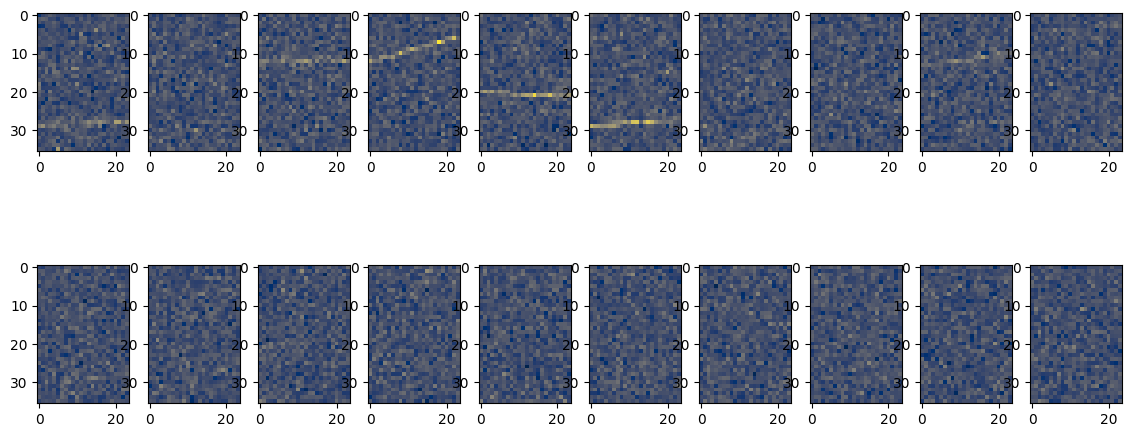

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (14, 6))
ind=3
vmin,vmax = odd_imgs[:10, :2].min(), odd_imgs[:10, :2].max()
for i in range(10):
    ax[0, i].imshow(odd_imgs[i,0].T, cmap="cividis",vmin=vmin, vmax=vmax)

for i in range(10):
    ax[1, i].imshow(odd_imgs[int(len(odd_imgs)/2) + i,0].T, cmap="cividis",vmin=vmin, vmax=vmax)
#ax.set_title(odd_labels[ind])

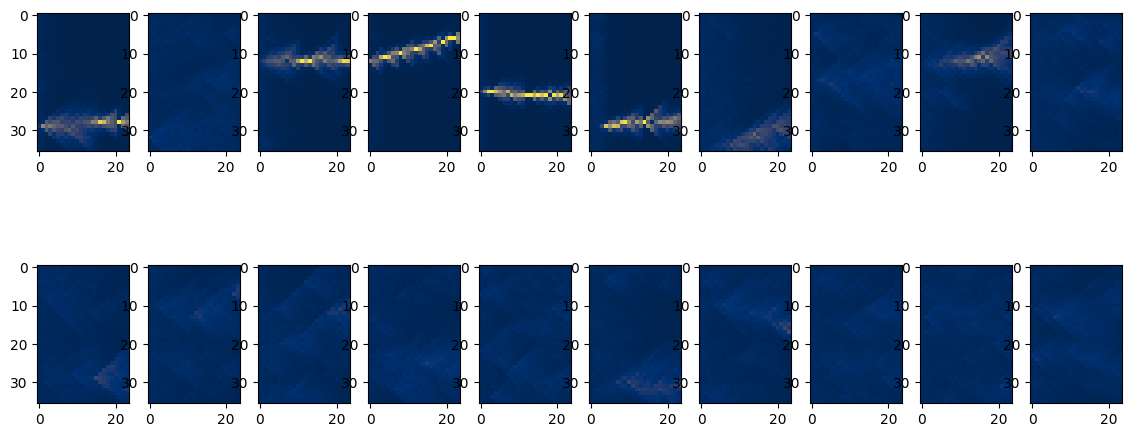

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (14, 6))
ind=3
vmin,vmax = odd_imgs[:10, 2].min(), odd_imgs[:10, 2].max() -0.3
for i in range(10):
    img = ax[0, i].imshow(odd_imgs[i,2].T, cmap="cividis",vmin=vmin, vmax=vmax)
for i in range(10):
    img = ax[1, i].imshow(odd_imgs[int(len(odd_imgs)/2) + i,2].T, cmap="cividis",vmin=vmin, vmax=vmax)
#ax.set_title(odd_labels[ind])

SOAP can be run on all examples in this folder, we can use the included files as the lookup tables

In [53]:
even_soapouts = np.zeros(len(even_imgs))
for index in range(len(even_imgs)):
    out = soapcw.two_detector(transition_matrix, even_imgs[index][0], even_imgs[index][1])
    # soapcw.two_detector(transition_matrix, H_imgs[index], L_imgs[index], lookup_table)
    even_soapouts[index] = out.max_end_prob

In [54]:
odd_soapouts = np.zeros(len(odd_imgs))
for index in range(len(odd_imgs)):
    out = soapcw.two_detector(transition_matrix, odd_imgs[index][0], odd_imgs[index][1])
    # soapcw.two_detector(transition_matrix, H_imgs[index], L_imgs[index], lookup_table)
    odd_soapouts[index] = out.max_end_prob

In [55]:
print(even_soapouts[:10])
print(even_stats[:10])

[6769.74853516 5152.43994141 5531.70361328 6351.11474609 5631.05566406
 5716.39501953 6185.93554688 6507.26318359 7149.62011719 5921.17919922]
[ -3.20402431 -26.58565521 -22.78729439  -7.2305007  -24.29245567
 -18.85527611 -11.24291801  -7.92858887   9.87887669 -18.24053383]


Text(0.5, 1.0, 'Summed statistic')

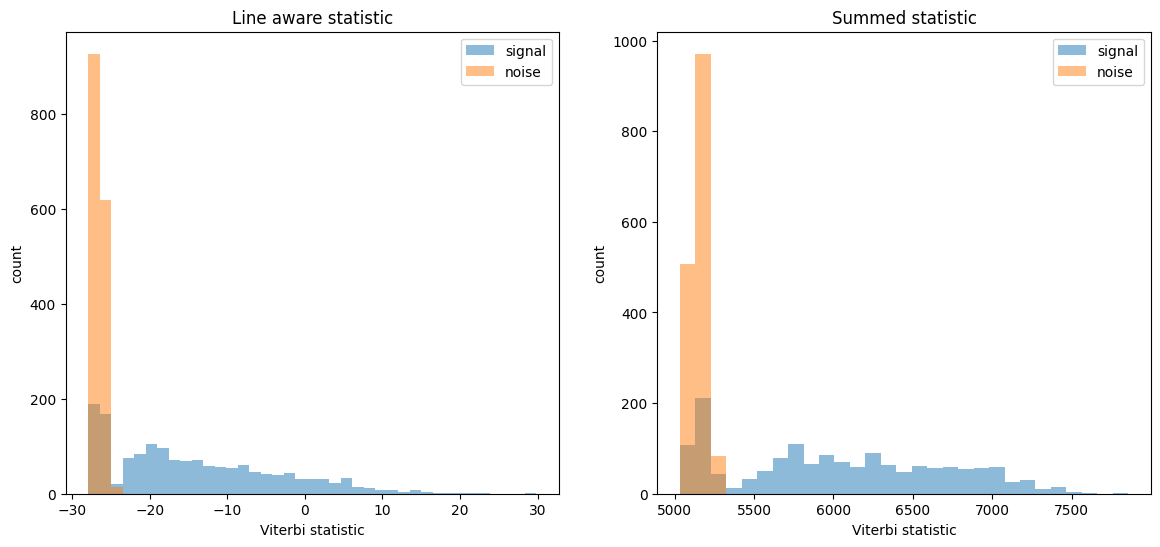

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
bins = np.linspace(min(odd_stats), max(odd_stats), 40)
hst = ax[0].hist(odd_stats[even_labels == 1], bins=bins, label="signal", alpha=0.5)
hst2 = ax[0].hist(odd_stats[even_labels == 0], bins=bins, label="noise", alpha=0.5)
ax[0].legend()
ax[0].set_xlabel("Viterbi statistic")
ax[0].set_ylabel("count")
ax[0].set_title("Line aware statistic")

bins = np.linspace(min(odd_soapouts), max(odd_soapouts), 30)
hst = ax[1].hist(odd_soapouts[even_labels == 1], bins=bins, label="signal", alpha=0.5)
hst2 = ax[1].hist(odd_soapouts[even_labels == 0], bins=bins, label="noise", alpha=0.5)
ax[1].legend()
ax[1].set_xlabel("Viterbi statistic")
ax[1].set_ylabel("count")
ax[1].set_title("Summed statistic")

# Machine Learning

So far we have a dataset from which we want to learn if a signal is present. This falls into the category of binary classification, where we want the model to predict how probable it is that a signal is present. When dealing with binary classification we want to minimise the Binary cross entropy between the truth and the predicted output. This is defined by

### Model Setup

We can define some parameters of out model here:

In [20]:
in_channels = 3                                             # [H,L,vitmap]
outsize = 2                                                 # [noise_prob, signal_prob]
n_epochs = 4000                                             # number times all data is seen
learning_rate = 2e-4                                        # learning rate of the adam optimiser
device = "cuda:0" if torch.cuda.is_available() else "cpu"   # which device to put the model and data on (i.e. CPU or GPU if available)

you can print what gpus are available

In [125]:
print(torch.cuda.device_count())

0


We can also check the size of our input spectrograms

In [126]:
#imgshape
print(odd_imgs.shape)
print(even_imgs.shape)

torch.Size([3120, 3, 24, 36])
torch.Size([3120, 3, 24, 36])


The sequential model below is a simple way to build models, each layer follows the next.

In [127]:
cnn = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, 4, (7,7), padding="same"),
    torch.nn.MaxPool2d((1,2)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 4, (3,3)),
    torch.nn.MaxPool2d((1,2)),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.LazyLinear(16),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(8),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(outsize)
).to(device)

/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


The same model can also be created via SOAP, an example of the same model structure can be seen below.     

In [128]:
model_soap = soapcw.cnn.pytorch.models.CNN(
    input_dim=(10,36),                          # the size of the input image
    fc_layers=[16, 8, 2],                       # the size of the fully connected mlp layers 
    conv_layers=[(4, 7, 2, 1), (4, 3, 2, 1)],   # the convolutional layers (num_filters, filter_size, maxpool_size, stride)
    inchannels=3, 
    avg_pool_size=(2,2),                        # the size of the average pooling layer 
    dropout=0.4,                                # the amount of dropout to use (default 0)
    device=device).to(device)                   # put the model on the chosen gpu or cpu

### Loss and Optimiser

It's at this stage that we specify the loss function to use and what optimiser to use.

The **optimiser** is the algorithm that is used to explore the parameter space of the network weights. In this example we're going to use `Adam` with a learning rate of 0.001 and the other parameters left as their default values. There a various different optimisers to choose from but Adam has proven to be realiable for a wide variety of problems and is a good place to start.

We then need to define the function that will quantify the network's performance, the **loss function**. In this case we're using **Categorical Crossentropy**. This combined with the **Softmax layer** means the network will ouput a vector of probabilities for each samples where each probability corresponds to a particular class.

For this binary (noise/signal) case it can written as:

$$f(\theta) = - \sum_{i \in S} log(\theta_{i}^{S}) - \sum_{i \in N} log(\theta_{i}^{N})$$

where $\theta_{i}^{S/N}$ is the predicted probability of class signal-noise (S) or noise-only (N)

In [129]:
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [130]:
def train_batch(model, optimiser, loss_function, data, labels, train=True):
    """
    Compute the loss for one batch of training/validation data. If train=True update the model.
    Args
    -------
    model: 
        pytorch model
    optimiser:
    loss_function:
    data: Tensor
    labels: Tensor
    train: bool
        if true updates the model weights and optimiser
    """
    model.train(train)
    if not train:
        model.eval()
        
    # zero the gradients so they do not grow with time
    if train:
        optimiser.zero_grad()

    # pass the data through the model to get two outputs (prob noise, prob signal)
    outputs = model(data)
    # computs the loss from our outputs and labels
    loss = loss_function(outputs, labels)

    if train:
        # perform a backward pass computing the gradients within the network
        loss.backward()
        # take a step in the direction of these gradients
        optimiser.step()

    return loss.item()


We define a normalisation constant for the data. This is because the data is of order 100, whereas networks generally like numbers of order 1 as this can help mitigate problems with gradient explosions or vanishing.

In [131]:
norm_const = even_imgs.max()

Move all the data to the GPU (if the gpu is available) and normalise to this normalisation constant.

In [132]:
even_imgs = torch.Tensor(even_imgs).to(device)/norm_const
odd_imgs = torch.Tensor(odd_imgs).to(device)/norm_const
even_onehotlabels = even_onehotlabels.to(device)
odd_onehotlabels = odd_onehotlabels.to(device)

We can now write out simple training loop and train our model. 

In [133]:
tr_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)

# define a random 200 indices for the validation data
val_inds = np.random.uniform(0, len(odd_imgs), 200).astype(int)

for epoch in range(n_epochs):

    # train a batch on all of the "even" data
    tr_loss = train_batch(cnn, optimiser, loss_fn, even_imgs[:,:], even_onehotlabels, train=True)

    # dont compute gradients for the test data 
    with torch.no_grad():
        val_loss = train_batch(cnn, optimiser, loss_fn, odd_imgs[val_inds,:], odd_onehotlabels[val_inds], train=False)

    # save the training and validation losses to array to look at later
    tr_losses[epoch] = tr_loss
    val_losses[epoch] = val_loss

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss: {tr_loss}, val_loss: {val_loss}")

Epoch: 0, loss: 0.7023295760154724, val_loss: 0.6984360218048096
Epoch: 50, loss: 0.7003333568572998, val_loss: 0.6975685358047485
Epoch: 100, loss: 0.698172926902771, val_loss: 0.6969342827796936
Epoch: 150, loss: 0.6956524848937988, val_loss: 0.6964665055274963
Epoch: 200, loss: 0.695499062538147, val_loss: 0.6952002644538879
Epoch: 250, loss: 0.6953988075256348, val_loss: 0.6942951679229736
Epoch: 300, loss: 0.6949941515922546, val_loss: 0.693429172039032
Epoch: 350, loss: 0.6951091289520264, val_loss: 0.6929163932800293
Epoch: 400, loss: 0.6951010823249817, val_loss: 0.6925130486488342
Epoch: 450, loss: 0.6950718760490417, val_loss: 0.6922545433044434
Epoch: 500, loss: 0.6945852637290955, val_loss: 0.6922453045845032
Epoch: 550, loss: 0.6945918202400208, val_loss: 0.6922860741615295
Epoch: 600, loss: 0.6939965486526489, val_loss: 0.6922586560249329
Epoch: 650, loss: 0.6931399703025818, val_loss: 0.6900375485420227
Epoch: 700, loss: 0.6918702125549316, val_loss: 0.6886528134346008
E

We can have a look at how the loss evolves during training. 

Text(0, 0.5, 'Loss')

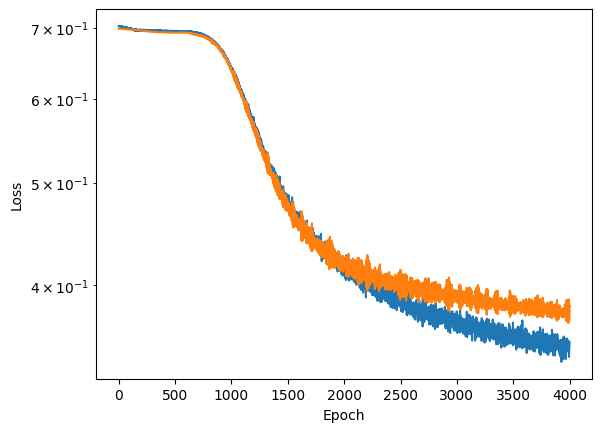

In [134]:
fig, ax = plt.subplots()
ax.plot(tr_losses, label="Training loss")
ax.plot(val_losses, label="Validation Loss")
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

We can now test this method on the "odd" bands to see how it performs on data it has not yet seen

In [135]:
cnn.eval()
with torch.no_grad():
    odd_outputs = cnn(torch.Tensor(odd_imgs[:,:])).cpu()

We can compute how well the cnn and SOAP performs by measuring the true positive rate at a false alarm of 1%.

In [136]:
# compute 1% false alarm from noise only bands
cnn_99per = sorted(odd_outputs[odd_labels==0][:,0])[int(0.99*len(odd_outputs[odd_labels==0]))]
soap_99per = sorted(odd_soapouts[odd_labels==0])[int(0.99*len(odd_outputs[odd_labels==0]))]
print(cnn_99per.numpy(), soap_99per)
# compute fraction of signals that cross the 1% false alarm (efficiency)
cnn_sigfrac = sum(odd_outputs[odd_labels==1][:,1] > cnn_99per)/len(odd_outputs[odd_labels==1])
soap_sigfrac = sum(odd_soapouts[odd_labels==1] > soap_99per)/len(odd_outputs[odd_labels==1])
print("cnn true positive rate: ", cnn_sigfrac.numpy())
print("soap true positive rate: ", soap_sigfrac)

1.5671774 5269.40771484375
cnn true positive rate:  0.7192308
soap true positive rate:  0.7788461538461539


We can see that it reaches close to the same sensitivity on this dataset with only a small amount of training and a small network.

/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0, 0.5, 'N bands')

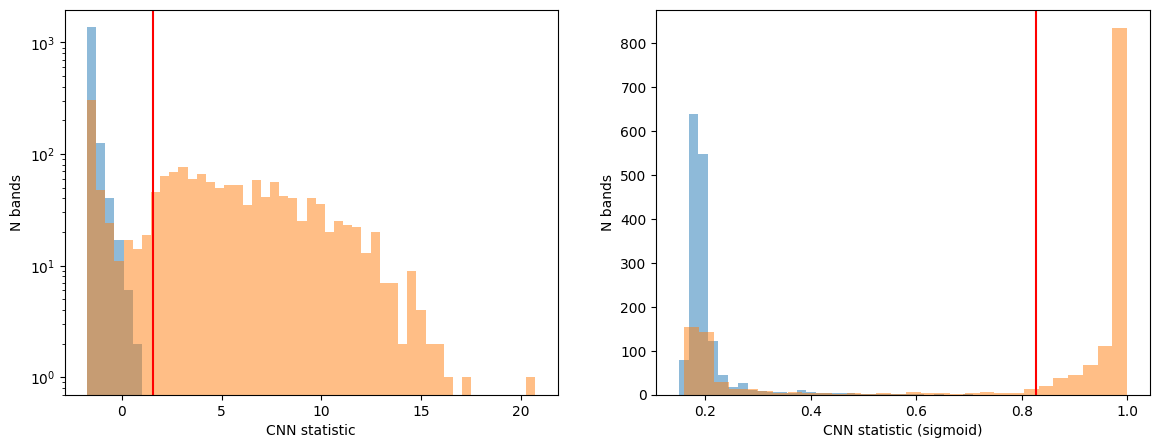

In [137]:
fig, ax = plt.subplots(ncols = 2, figsize=(14,5))
bins = np.linspace(odd_outputs[odd_labels==0][:,1].min(), odd_outputs[odd_labels==1][:,1].max(), 50)
h11 = ax[0].hist(odd_outputs[odd_labels==0][:,1], bins=bins, alpha=0.5)
h12 = ax[0].hist(odd_outputs[odd_labels==1][:,1], bins=bins, alpha=0.5)
ax[0].axvline(cnn_99per, color="r")
ax[0].set_yscale("log")
h11 = ax[1].hist(torch.nn.functional.sigmoid(odd_outputs[odd_labels==0][:,1]), bins=30, alpha=0.5)
h12 = ax[1].hist(torch.nn.functional.sigmoid(odd_outputs[odd_labels==1][:,1]), bins=30, alpha=0.5)
ax[1].axvline(torch.nn.functional.sigmoid(cnn_99per), color="r")
ax[0].set_xlabel("CNN statistic")
ax[1].set_xlabel("CNN statistic (sigmoid)")
ax[0].set_ylabel("N bands")
ax[1].set_ylabel("N bands")

# Challenge

Can you write a network that also makes some point predictions of some parameters?

## Loading a pretrained model
Links to other pretrained models are in the ligo private pages here if needed, I've provided an example in this repo for those who do not have access.

In [138]:
model_soap, model_config = soapcw.cnn.pytorch.load_model_from_config(
        config_file, 
        weight_file, 
        device=device)

This can be tested on the above data (this is not an entirely fair test as the SNR distributions and data it was trained on are slightly different)

In [139]:
model_soap.eval()
with torch.no_grad():
    s_odd_outputs = model_soap(torch.Tensor(odd_imgs)).cpu()

Text(0, 0.5, 'N bands')

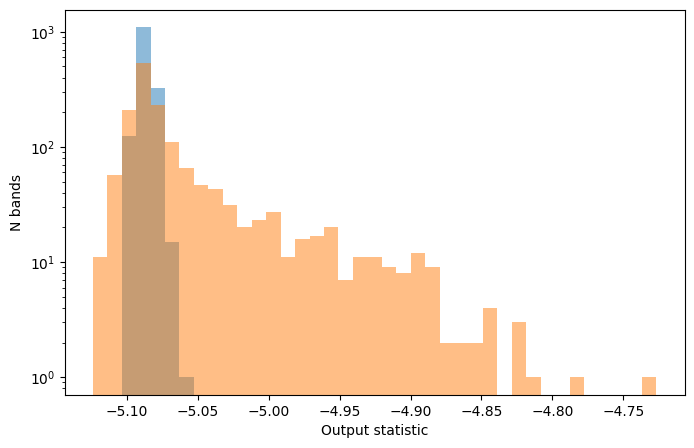

In [142]:
fig, ax = plt.subplots(ncols = 1, figsize=(8,5))
bins = np.linspace(min(s_odd_outputs[:,1]), max(s_odd_outputs[:,1]), 40)
h11 = ax.hist(s_odd_outputs[odd_labels==0][:,1], alpha=0.5, bins=bins)
h12 = ax.hist(s_odd_outputs[odd_labels==1][:,1], alpha=0.5, bins=bins)
ax.set_yscale("log")
ax.set_xlabel("Output statistic")
ax.set_ylabel("N bands")

We can test this network on the data we simulated at the start of this notebook

In [147]:
test_data = torch.unsqueeze(torch.Tensor(np.stack([spect.H1.summed_norm_sft_power.T, spect.L1.summed_norm_sft_power.T, soapout.vitmap.T])), 0)
test_data.shape

torch.Size([1, 3, 180, 200])

In [148]:
with torch.no_grad():
    s_odd_test = model_soap(test_data)

In [149]:
torch.nn.functional.sigmoid(s_odd_test)

tensor([[0., 1.]])

# Neville 

Neville is the parameter estimation part of SOAP to followup on interesting candidates. 

This is not yet integrated into the SOAP package, but will be within the next few months. Here I provide an example of a pretrained model and how it would be used. 

In [24]:
sys.path.append("./neville")   # append the path for the cvae file
from cvae_frac_trunc import CVAE
import corner
import pickle

In [32]:
neville_model = soapcw.neville.load_models.load_model_from_config("./pretrained_model_config/model.ini","./neville/model_state_dict.pt", device=device)

Key not in defaults: neville, num_predict_params
Key not in defaults: neville, stride
Key not in defaults: neville, dropout


TypeError: __init__() got an unexpected keyword argument 'output_dim'

In [25]:
par_weights = torch.load("neville/model.pt", map_location=device).to(device)
par_weights.device = device

In [33]:
par_weights.latent_dim

16

In [26]:
par_weights.state_dict

<bound method Module.state_dict of CVAE(
  (activation): ReLU()
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (drop): Dropout(p=0.0, inplace=False)
  (mu_r): Linear(in_features=128, out_features=16, bias=True)
  (log_var_r): Linear(in_features=128, out_features=16, bias=True)
  (rencoder_conv): Sequential(
    (r_conv0): Conv1d(1, 4, kernel_size=(4,), stride=(1,), padding=(2,))
    (act_r_conv0): ReLU()
    (pool_r_conv0): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (r_conv1): Conv1d(4, 4, kernel_size=(4,), stride=(1,), padding=(2,))
    (act_r_conv1): ReLU()
    (pool_r_conv1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (rencoder_lin): Sequential(
    (r_lin0): Linear(in_features=89, out_features=128, bias=True)
    (r_drop0): Dropout(p=0.0, inplace=False)
    (act_r_lin0): ReLU()
    (r_lin1): Linear(in_features=128, out_features=128, bias=True)
    (r_drop1): Dropout(p=0.0, inplace=False)
    (act_r_lin1): ReLU()
 

In [27]:
torch.save(
    {
        "model_state_dict": par_weights.state_dict
    },
    "./neville/model_state_dict.pt"
)

In [28]:
msd = torch.load("./neville/model_state_dict.pt")

Here we have just padded the input with a fixed value. This is because the model above was trained on 362 days of data and above we have 200 days of data.

We also normalise the inputs to be between 0 and 1. As the above model was trained on data in 0.1 Hz bands, the bin index went between 0 and 180, we divide by the 180.

In [286]:
# pad and reshape to be input to model
app_length = 362 - len(soapout.vit_track1)
randtrack = [soapout.vit_track1[-1]]
for i in range(app_length - 1):
    randtrack.append(randtrack[-1] + np.random.randint(low=0,high=3, size=1) - 1)
track_input = np.append(soapout.vit_track1, randtrack).astype(float)
track_input = np.expand_dims(np.expand_dims(track_input, 0), 0)
# also normalise the inputs to go between 0 and 1
track_input = track_input/(180)

/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [102]:
with open("./test_data_tracks.pkl","rb") as f:
    track_data = pickle.load(f)
with open("./test_labels_track.pkl","rb") as f:
    track_labels = pickle.load(f)
with open("./test_parameters_tracks.pkl","rb") as f:
    track_parameters = pickle.load(f)

In [128]:
track_parameters[400]

{'f': 100.42946760305558,
 'fd': -3.122941787828923e-10,
 'alpha': 6.073415355613761,
 'sindelta': 0.7616103426843356,
 'phi0': 3.2744671520417996,
 'psi': 0.23118380408304895,
 'cosi': -0.8877819159171894,
 'tref': 1238166483.0,
 'snr': 93,
 'av_sh': 2.489749998157524e-44,
 'h0': 1.4571007571383648e-67,
 'depth': 1.082899832405013e+45,
 'width': 0.1,
 'fmin': 100.4,
 'fmax': 100.5,
 'delta': 0.865794461033658,
 'lon': 0.2754141882996348,
 'lat': 0.8517530709726144,
 'fdot': -3.122941787828923e-10}

In [125]:
fs = [track_parameters[i]["f"] for i in range(len(track_parameters))]

In [127]:
np.argmin(np.abs(np.array(fs) - 100.0))

400

Text(0, 0.5, 'normalised frequency offset')

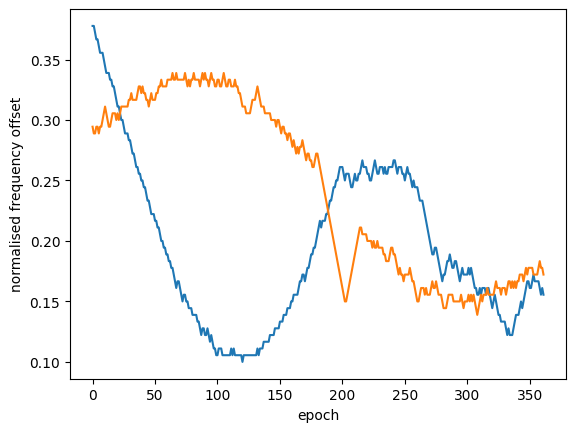

In [284]:
fig, ax = plt.subplots()
ax.plot(track_input[0][0])
ax.plot(track_data[400][0])
ax.set_xlabel("epoch")
ax.set_ylabel("normalised frequency offset")

In [108]:
samps = par_weights.test(torch.Tensor(track_data[2:3]).to(torch.float64), freqs=torch.Tensor([154.4,]), num_samples=1000)

index: 0


In [287]:
samps = par_weights.test(torch.Tensor(track_input).to(torch.float64), freqs=torch.Tensor([100.0,]), num_samples=1000)
# renormalise samples
samps[0][:,:,0] = np.remainder(samps[0][:,:,0]*2*np.pi, 2*np.pi)
samps[0][:,:,1] = np.abs(samps[0][:,:,1])*0.5*np.pi
samps[0][:,:,3] = (samps[0][:,:,3]*2 - 1)*1e-9
samps[0][:,:,2] = samps[0][:,:,2]*0.1 + 200

index: 0


Text(0, 0.5, 'normalised frequency offset')

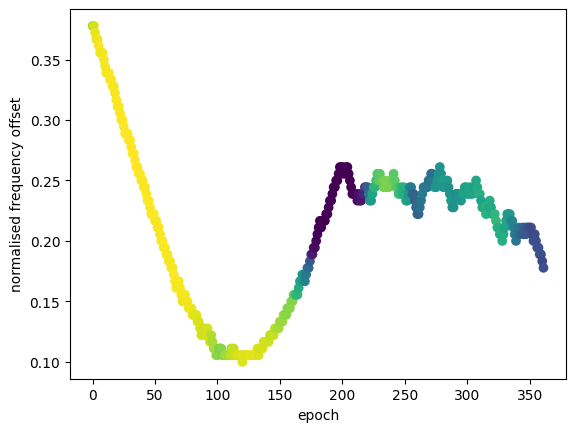

In [288]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(track_input[0][0])), track_input[0][0], c = samps[2].mean(axis=1)[0])
ax.set_xlabel("epoch")
ax.set_ylabel("normalised frequency offset")

In [289]:
parameters = [sig.alpha, np.abs(sig.delta), sig.f[0], sig.f[1]]
print(parameters)
#parameters = [sig.alpha/(2*np.pi), np.abs(sig.delta/(0.5*np.pi)), (sig.f[0] - 200.0)/0.1, (sig.f[1]/1e9 + 1)/2 ]
print(parameters)

[3.7659, 0.06, 200.03, -3.65e-11]
[3.7659, 0.06, 200.03, -3.65e-11]


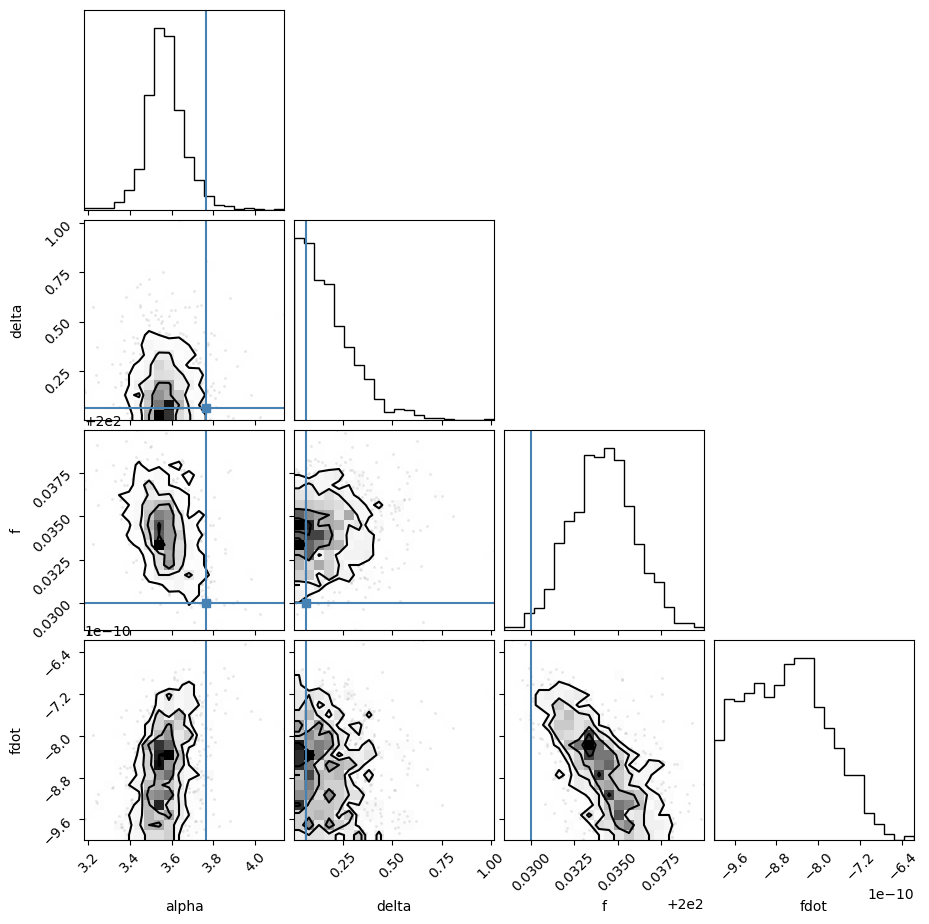

In [290]:
corner_fig = corner.corner(samps[0][0], labels=["alpha", "delta", "f", "fdot"], truths=parameters)